# Map of contributions to the IP
Here we plot maps of contributions to the ionospheric potential (IP) during different MJO phases.

## Imports

In [1]:
# data processing
import numpy as np

# plotting the data
import matplotlib.pyplot as plt

# maps
import cartopy.crs as ccrs

# colours
from matplotlib import cm

## Loading the data and calculating RMM phases

In [2]:
map_contrib = np.load('./data/DAILY-IP-MAP-V4.3.npy')
# original data with the shape (number of days, number of latitudes, number of longitudes)
# contains IP values (not normalised) depending on (d, lat, lon)
# d (axis 0) is the number of a day starting with 0 and ending with 4991
# every third day is taken, 0 corresponds to 1 Jan 1980 and 4991 corresponds to 29 Dec 2020
# lat (axis 1) describes the latitude (an integer in [0, 180])
# lon (axis 2) describes the longitude (an integer in [0, 360])

map_contrib /= np.mean(np.sum(map_contrib, axis=(1, 2)))
map_contrib *= 240e3
# normalisation of contributions to the IP to the global mean of 240 kV

avg_map_contrib = np.mean(map_contrib, axis=0)  # long-term means of contributions

rmm = np.genfromtxt('./data/rmm.txt')
rmm = rmm[::3, [3, 4]]  # RMM1 and RMM2
# the array should look like the IP data (with every third day taken)
angle_rmm = np.arctan2(rmm[:, 1], rmm[:, 0])  # phase angles of RMM values
phase_rmm = np.floor((angle_rmm / np.pi + 1) * 4).astype(int)  # phase numbers

# phase separation
phase_avg_map_contrib = np.zeros(
    (8, map_contrib.shape[1], map_contrib.shape[2]),
    dtype=float
    )
counter = np.zeros((8), dtype=int)

for i in range(len(phase_rmm)):
    counter[phase_rmm[i]] += 1
    phase_avg_map_contrib[phase_rmm[i]] += map_contrib[i]  # summing over each phase

phase_avg_map_contrib /= counter[:, np.newaxis, np.newaxis]  # averaging over each phase

dev_map_contrib = phase_avg_map_contrib - avg_map_contrib  # deviations from the long-term means
# (i.e. anomalies)

## How much does the region lying between 15°S and 15°N contribute to the IP?

In [3]:
print(f'{np.sum(avg_map_contrib[75:-75, :]) / np.sum(avg_map_contrib[:, :]):.2%}')
# note that the denominator is actually nothing but 240e3

86.37%


## Plots

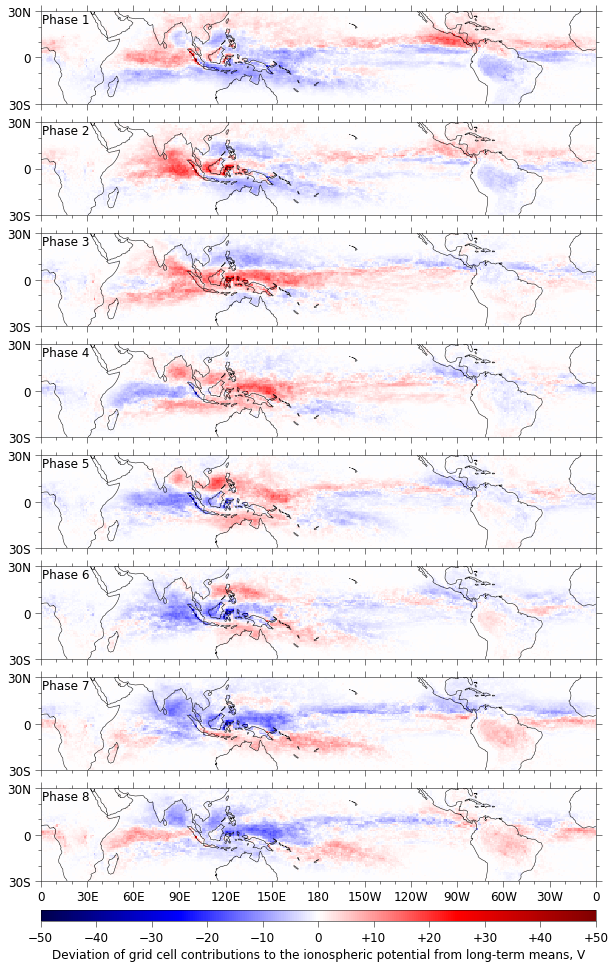

In [4]:
fig = plt.figure(figsize=(12, 16))
ax = [None for _ in range(8)]
im = [None for _ in range(8)]

cmap = cm.get_cmap('seismic', 256) 
clim = np.ceil(
    max(
        -np.amin(dev_map_contrib),
        np.amax(dev_map_contrib)
    ) / 10
) * 10  # the bound of the colour bar (a multiple of 10 V)

for i in range(8):
    ax[i] = fig.add_subplot(8, 1, i+1,
                            projection=ccrs.PlateCarree(central_longitude=180))
    ax[i].coastlines('110m', linewidth=0.5)
    im[i] = ax[i].imshow(dev_map_contrib[i, 60:-60, :], cmap=cmap,
                         extent=[-180, 180, 30, -30], clim=(-clim, clim),
                         interpolation='none')

    ax[i].text(0.002, 0.98, f'Phase {i+1}', ha='left', va='top',
               transform=ax[i].transAxes, fontsize='large')

    ax[i].set_xlim(-180, 180)
    ax[i].set_ylim(-30, 30)

    ax[i].spines['geo'].set_linewidth(0.5)
    ax[i].tick_params(top=True, right=True, which='both')
    ax[i].tick_params(length=6, width=0.5)
    ax[i].tick_params(length=3, width=0.5, which='minor')

    ax[i].set_xticks(np.arange(-180, 180+1, 30))
    ax[i].set_xticks(np.arange(-180, 180+1, 10), minor=True)
    ax[i].set_xticklabels([])
    ax[i].set_yticks(np.arange(-30, 30+1, 30))
    ax[i].set_yticks(np.arange(-30, 30+1, 10), minor=True)
    ax[i].set_yticklabels(['30S', '0', '30N'],
                          fontsize='large')

ax[7].set_xticklabels(['0', '30E', '60E', '90E', '120E', '150E', '180',
                       '150W', '120W', '90W', '60W', '30W', '0'],
                      fontsize='large')

# the colour bar
cax = fig.add_axes(
    [ax[7].get_position().x0, ax[7].get_position().y0-0.035,
     ax[7].get_position().x1-ax[7].get_position().x0, 0.01])
cbar = fig.colorbar(im[7], cax=cax, orientation='horizontal')

cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(length=6, width=0.5)

cbar.set_ticks(np.arange(-clim, clim+1, 10))
cbar.ax.set_xticklabels([f'−{-x:d}' if x < 0
                         else f'+{x:d}' if x > 0
                         else f'{x:d}'
                         for x in np.arange(-clim, clim+1, 10).astype(int)],
                        fontsize='large')
# for some reason cbar.set_ticklabels does not work with fontsize

cbar.set_label(('Deviation of grid cell contributions to the ionospheric '
                'potential from long-term means, V'), fontsize='large')

fig.savefig('figures/map_of_contributions.png', dpi=300, bbox_inches='tight')
fig.savefig('figures/map_of_contributions.eps', bbox_inches='tight')